In [2]:
import os
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.distributed as dist
import torch.multiprocessing as mp

In [7]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-db7b281b-c0e0-5734-ee06-89a33ec4002a)


In [3]:
# Taken from https://github.com/amitrajitbose/handwritten-digit-recognition/blob/master/handwritten_digit_recognition_GPU.ipynb
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #ps = ps.data.numpy().squeeze()
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [4]:
# Define the function to train the model
def train(model, criterion, optimizer, trainloader, device):
    model.train()
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

In [6]:
def main(rank, world_size):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,)),
                                   ])
    trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
    valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
    train_sampler = torch.utils.data.distributed.DistributedSampler(trainset, num_replicas=world_size, rank=rank)
    val_sampler = torch.utils.data.distributed.DistributedSampler(valset, num_replicas=world_size, rank=rank)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

    input_size = 784
    hidden_sizes = [128, 64]
    output_size = 10

    model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[1], output_size),
                          nn.LogSoftmax(dim=1))
    print(model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)

    model = nn.parallel.DistributedDataParallel(model, device_ids=[rank])

    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    criterion = nn.NLLLoss()

    time0 = time()
    epochs = 15
    for e in range(epochs):
        running_loss = 0
        train(model, criterion, optimizer, trainloader, device)
        model.eval()
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
            images = images.to(device)
            labels = labels.to(device)
            # Training pass
            optimizer.zero_grad()

            # output = model(images)
            output = model(images.cuda())
            # loss = criterion(output, labels)
            loss = criterion(output, labels.cuda())

            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss / len(trainloader)))
    print("\nTraining Time (in minutes) =", (time() - time0) / 60)

    images, labels = next(iter(valloader))

    img = images[0].view(1, 784)
    with torch.no_grad():
        logps = model(img.cuda())

    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    print("Predicted Digit =", probab.index(max(probab)))
    view_classify(img.view(1, 28, 28), ps)

    correct_count, all_count = 0, 0
    model.eval()
    for images, labels in valloader:
        images = images.view(images.shape[0], -1)
        images = images.to(device)
        labels = labels.to(device)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
            with torch.no_grad():
                # logps = model(img)
                # logps = model(img.cuda())
                logps = model(images.cuda())

            ps = torch.exp(logps)
            # probab = list(ps.numpy()[0])
            probab = list(ps.cpu().numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if true_label == pred_label:
                correct_count += 1
            all_count += 1

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy =", (correct_count / all_count))

if __name__ == '__main__':
    world_size = torch.cuda.device_count()
    mp.spawn(main, args=(world_size,), nprocs=world_size, join=True)

ProcessExitedException: ignored

In [ ]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
train_sampler = torch.utils.data.distributed.DistributedSampler(trainset, num_replicas=world_size, rank=rank)
val_sampler = torch.utils.data.distributed.DistributedSampler(valset, num_replicas=world_size, rank=rank)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 100206582.90it/s]


Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26629081.96it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26900348.89it/s]


Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5877978.64it/s]


Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 100764198.22it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 89333107.54it/s]


Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26682709.20it/s]


Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6691439.68it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



In [ ]:
#dataiter = iter(trainloader)
#images, labels = next(dataiter)

#print(images.shape)
#print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [ ]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

model = nn.parallel.DistributedDataParallel(model, device_ids=[rank])

cuda


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

In [ ]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

#logps = model(images) #log probabilities
#loss = criterion(logps, labels) #calculate the NLL loss
logps = model(images.cuda())
loss = criterion(logps, labels.cuda())

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
criterion = nn.NLLLoss()

time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    train(model, criterion, optimizer, trainloader, device)
    model.eval()
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        images = images.to(device)
        labels = labels.to(device)
        # Training pass
        optimizer.zero_grad()

        #output = model(images)
        output = model(images.cuda())
        #loss = criterion(output, labels)
        loss = criterion(output, labels.cuda())

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6422310824285565
Epoch 1 - Training loss: 0.282288758644163
Epoch 2 - Training loss: 0.2210679596929408
Epoch 3 - Training loss: 0.17923273048452984
Epoch 4 - Training loss: 0.14863360933125463
Epoch 5 - Training loss: 0.1293845973583236
Epoch 6 - Training loss: 0.11346691209616373
Epoch 7 - Training loss: 0.10121558321568408
Epoch 8 - Training loss: 0.09136480814330518
Epoch 9 - Training loss: 0.08128457342181156
Epoch 10 - Training loss: 0.07376065723615875
Epoch 11 - Training loss: 0.0681595038026889
Epoch 12 - Training loss: 0.06229767438097756
Epoch 13 - Training loss: 0.05712289481124938
Epoch 14 - Training loss: 0.052753992309706454

Training Time (in minutes) = 4.748829944928487


In [ ]:
# Taken from https://github.com/amitrajitbose/handwritten-digit-recognition/blob/master/handwritten_digit_recognition_GPU.ipynb
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #ps = ps.data.numpy().squeeze()
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 7


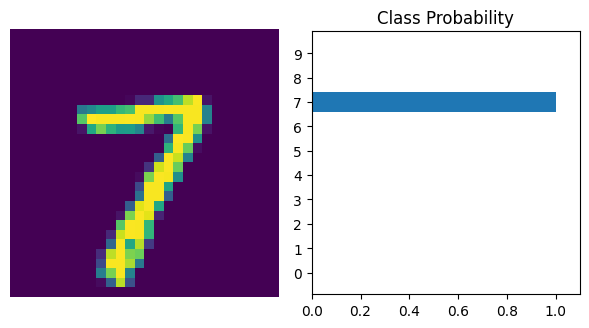

In [ ]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img.cuda())

ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [ ]:
correct_count, all_count = 0, 0
model.eval()
for images,labels in valloader:
    images = images.view(images.shape[0], -1)
    images = images.to(device)
    labels = labels.to(device)

#  for i in range(len(labels)):
#    img = images[i].view(1, 784)
    with torch.no_grad():
        #logps = model(img)
        #logps = model(img.cuda())
        logps = model.(images.cuda())

    ps = torch.exp(logps)
    #probab = list(ps.numpy()[0])
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9751


In [ ]:
torch.save(model, './my_mnist_model.pt')

In [6]:
if __name__ == '__main__':
    world_size = torch.cuda.device_count()
    mp.spawn(main, args=(world_size,), nprocs=world_size)

ProcessExitedException: ignored

In [ ]:
# Tutorial references
# https://github.com/amitrajitbose/handwritten-digit-recognition/blob/master/handwritten_digit_recognition_GPU.ipynb
# https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627